# Walmart Weekly Sales Forecasting
This notebook performs data preprocessing, feature engineering, model training, and prediction using Random Forest and XGBoost.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

## 2. Load the Datasets

In [2]:
features = pd.read_csv("walmart-sales-forecast-dataset/features.csv")
stores = pd.read_csv("walmart-sales-forecast-dataset/stores.csv")
train = pd.read_csv("walmart-sales-forecast-dataset/train.csv")

## 3. Merge the Datasets

In [3]:
df = train.merge(features, on=["Store", "Date", "IsHoliday"], how="left")
df = df.merge(stores, on="Store", how="left")

## 4. Convert Date Column to Datetime

In [4]:
df["Date"] = pd.to_datetime(df["Date"])

## 5. Sort by Store, Department, and Date

In [5]:
df = df.sort_values(["Store", "Dept", "Date"]).reset_index(drop=True)

## 6. Create Time-Based Features

In [6]:
df["day"] = df["Date"].dt.day
df["week"] = df["Date"].dt.isocalendar().week.astype(int)
df["month"] = df["Date"].dt.month
df["year"] = df["Date"].dt.year

## 7. Create Lag Features

In [7]:
df["lag_1"] = df.groupby(["Store", "Dept"])["Weekly_Sales"].shift(1)
df["lag_2"] = df.groupby(["Store", "Dept"])["Weekly_Sales"].shift(2)
df["lag_52"] = df.groupby(["Store", "Dept"])["Weekly_Sales"].shift(52)

## 8. Create Rolling Window Features

In [8]:
df["rolling_4"] = df.groupby(["Store", "Dept"])["Weekly_Sales"].transform(lambda x: x.shift(1).rolling(4).mean())
df["rolling_12"] = df.groupby(["Store", "Dept"])["Weekly_Sales"].transform(lambda x: x.shift(1).rolling(12).mean())

## 9. Drop Missing Rows Caused by Lagging

In [9]:
df = df.dropna()

## 10. Select Feature Columns

In [10]:
feature_cols = [
    "Temperature", "Fuel_Price", "CPI", "Unemployment",
    "day", "week", "month", "year",
    "lag_1", "lag_2", "lag_52",
    "rolling_4", "rolling_12",
    "Size"
]

X = df[feature_cols]
y = df["Weekly_Sales"]

## 11. Time-Aware Train/Test Split

In [11]:
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

## 12. Train Random Forest Model

In [12]:
model = RandomForestRegressor(n_estimators=150, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

2944.714459955666

## 13. Plot Actual vs Predicted

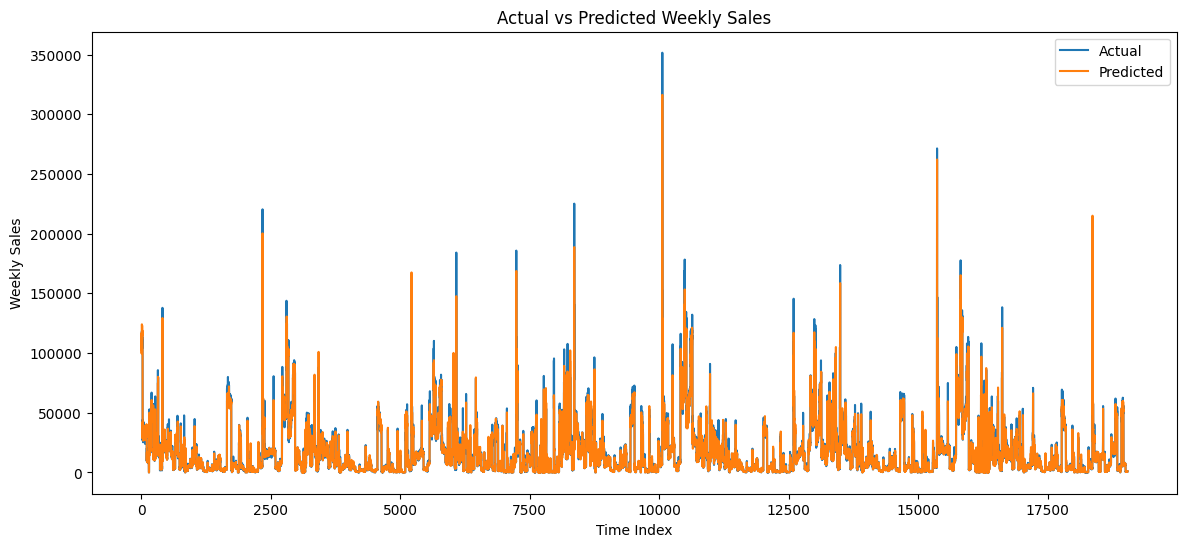

In [13]:
plt.figure(figsize=(14,6))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("Actual vs Predicted Weekly Sales")
plt.xlabel("Time Index")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()  

## 14. Train XGBoost Model

In [14]:
xgb = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror"
)

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
print("RMSE:", rmse)

RMSE: 2985.015806074742


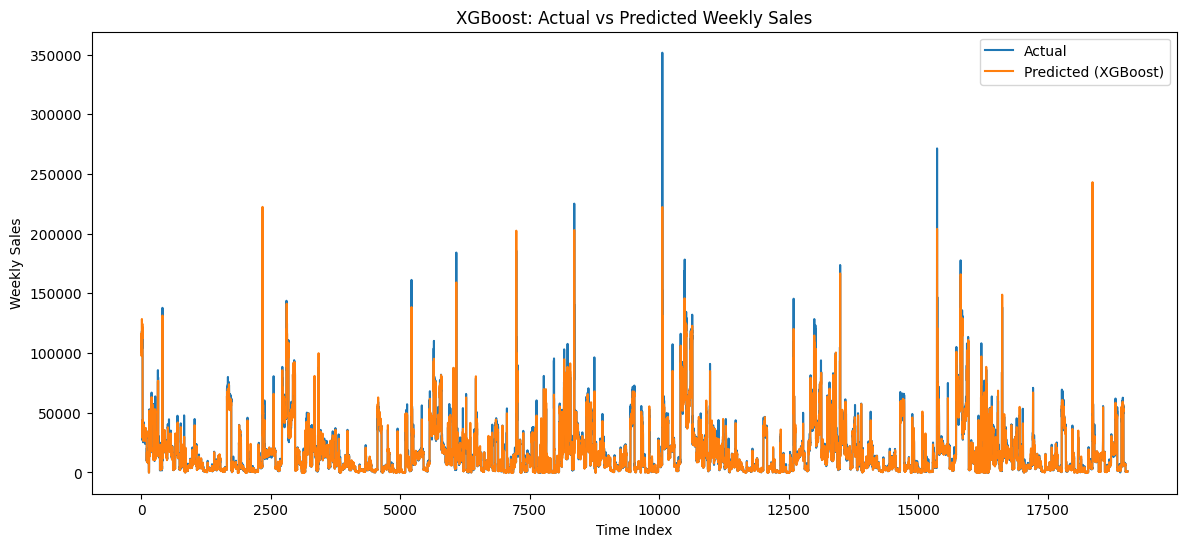

In [15]:
plt.figure(figsize=(14,6))
plt.plot(y_test.values, label="Actual")
plt.plot(xgb_pred, label="Predicted (XGBoost)")
plt.title("XGBoost: Actual vs Predicted Weekly Sales")
plt.xlabel("Time Index")
plt.ylabel("Weekly Sales")
plt.legend()

## 15. Load Test Data and Merge with Features

In [16]:
test = pd.read_csv("walmart-sales-forecast-dataset/test.csv")

test_full = test.merge(features, on=["Store", "Date", "IsHoliday"], how="left")
test_full = test_full.merge(stores, on="Store", how="left")

test_full["Date"] = pd.to_datetime(test_full["Date"])

test_full["day"] = test_full["Date"].dt.day
test_full["week"] = test_full["Date"].dt.isocalendar().week.astype(int)
test_full["month"] = test_full["Date"].dt.month
test_full["year"] = test_full["Date"].dt.year

## 16. Build Full DataFrame for Lagging

In [17]:
full = pd.concat([df, test_full], sort=False)
full = full.sort_values(["Store", "Dept", "Date"])

full["lag_1"] = full.groupby(["Store", "Dept"])["Weekly_Sales"].shift(1)
full["lag_2"] = full.groupby(["Store", "Dept"])["Weekly_Sales"].shift(2)
full["lag_52"] = full.groupby(["Store", "Dept"])["Weekly_Sales"].shift(52)

full["rolling_4"] = full.groupby(["Store", "Dept"])["Weekly_Sales"].shift(1).rolling(4).mean()
full["rolling_12"] = full.groupby(["Store", "Dept"])["Weekly_Sales"].shift(1).rolling(12).mean()

test_processed = full.loc[test_full.index]

## 17. Predict Test Data

In [18]:
test_predictions = xgb.predict(test_processed[feature_cols])
test_processed["Weekly_Sales_Pred"] = test_predictions

test_processed[["Store", "Dept", "Date", "Weekly_Sales_Pred"]].head()

,Store,Dept,Date,Weekly_Sales_Pred
0,1,1,2012-11-02,107624.218750
1,1,1,2012-11-09,181540.765625
2,1,1,2012-11-16,192287.265625
3,1,1,2012-11-23,199766.234375
4,1,1,2012-11-30,181567.265625
